# Bike Availability Analysis


In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
path = "/Users/sreevathsadb/Masters/Project/Data/"
import plotly.express as px
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_rows', 17544) 
%matplotlib inline

# Configuring plotting visual and sizes
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [2]:
path = "/Users/sreevathsadb/Masters/Project/Data/"
path = path + 'dublin_bikes/' # use your path
#file_paths = glob.glob(path + "20*")
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018','2019', '2020',
       '2021', '2022']
selected = ['2016', '2017', '2018','2019', '2020','2021']

data = []
for i in range(0,len(selected)):
    #print(path+str(pre_post_covid[i])+'.csv')
    temp_data = pd.read_csv(path+str(selected[i])+'.csv', index_col=None, header=0)
    data.append(temp_data)
data = pd.concat(data, axis=0, ignore_index=True)
data.shape

(47292318, 22)

In [3]:
#(37470767, 17)
data.drop_duplicates()
data.shape

(47292318, 22)

In [4]:
#remove incorrect/bad samples
data = data.drop(data[(data['available_bike_stands'] == 0) & (data['available_bikes'] == 0)].index)
data = data.drop(data[(data['available_bike_stands'] + data['available_bikes']) != data['total_bike_stands']].index)
data.shape

(45150644, 22)

In [5]:
data.columns

Index(['id', 'timestamp', 'total_bike_stands', 'available_bike_stands',
       'available_bikes', 'year', 'month', 'day', 'hour', 'minute', 'weekday',
       'number', 'name', 'latitude', 'longitude', 'holiday', 'season',
       'date_for_merge', 'rain', 'temp', 'wdsp', 'wdsp_classified'],
      dtype='object')

In [6]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
#data['time'] = data['timestamp'].dt.time
data['date'] = data['timestamp'].dt.date
#data['date_for_merge'] = data['timestamp'].dt.round('H')
conditions = [
    (data['weekday'] == "Saturday"),
    (data['weekday'] == "Sunday"),
    ]
values = ["Saturday", "Sunday"]
data['day_type']  = np.select(conditions, values,default="Weekday")

conditions = [
    (data['hour'] < 6),
    (data['hour'] < 11),
    (data['hour'] < 16),
    (data['hour'] < 20),
    (data['hour'] <= 23)
    ]
values = ["Overnight ", "6AM-10AM ", "11AM-3PM ","4PM-7PM ","8PM-11PM "]
data['classified_time'] = np.select(conditions, values,default="Overnight ")
data['cluster_group'] = data['classified_time'] + data['day_type']

In [7]:
data.head(6)

,id,timestamp,total_bike_stands,available_bike_stands,available_bikes,year,month,day,hour,minute,weekday,number,name,latitude,longitude,holiday,season,date_for_merge,rain,temp,wdsp,wdsp_classified,date,day_type,classified_time,cluster_group
0,1,2016-01-01 00:00:02,29,28,1,2016,1,1,0,0,Friday,1,CLARENDON ROW,53.340883,-6.262542,New Year's Day,Winter,2016-01-01 00:00:00,0.0,1.9,8.0,Gentle breeze,2016-01-01,Weekday,Overnight,Overnight Weekday
1,1,2016-01-01 00:10:01,29,27,2,2016,1,1,0,10,Friday,1,CLARENDON ROW,53.340883,-6.262542,New Year's Day,Winter,2016-01-01 00:00:00,0.0,1.9,8.0,Gentle breeze,2016-01-01,Weekday,Overnight,Overnight Weekday
2,1,2016-01-01 00:20:02,29,26,3,2016,1,1,0,20,Friday,1,CLARENDON ROW,53.340883,-6.262542,New Year's Day,Winter,2016-01-01 00:00:00,0.0,1.9,8.0,Gentle breeze,2016-01-01,Weekday,Overnight,Overnight Weekday
3,1,2016-01-01 00:30:02,29,27,2,2016,1,1,0,30,Friday,1,CLARENDON ROW,53.340883,-6.262542,New Year's Day,Winter,2016-01-01 01:00:00,0.0,1.6,7.0,Gentle breeze,2016-01-01,Weekday,Overnight,Overnight Weekday
4,1,2016-01-01 00:40:02,29,28,1,2016,1,1,0,40,Friday,1,CLARENDON ROW,53.340883,-6.262542,New Year's Day,Winter,2016-01-01 01:00:00,0.0,1.6,7.0,Gentle breeze,2016-01-01,Weekday,Overnight,Overnight Weekday
5,1,2016-01-01 00:50:02,29,27,2,2016,1,1,0,50,Friday,1,CLARENDON ROW,53.340883,-6.262542,New Year's Day,Winter,2016-01-01 01:00:00,0.0,1.6,7.0,Gentle breeze,2016-01-01,Weekday,Overnight,Overnight Weekday


In [8]:
merged_data = data
merged_data = merged_data.sort_values(['id', 'timestamp'])

In [9]:
#create important features
merged_data['availability_percentage'] =  merged_data['available_bikes'] / merged_data['total_bike_stands']
merged_data['is_empty'] = np.where(merged_data['availability_percentage'] == 0, 1,0)
merged_data['is_full'] = np.where(merged_data['availability_percentage'] == 1, 1,0)

In [10]:
null_data = merged_data[merged_data.isnull().any(axis=1)]
len(null_data)

0

#### Stations Bike Availablity

Text(0.5, 1.0, 'Total Trips across Dublin Stations')

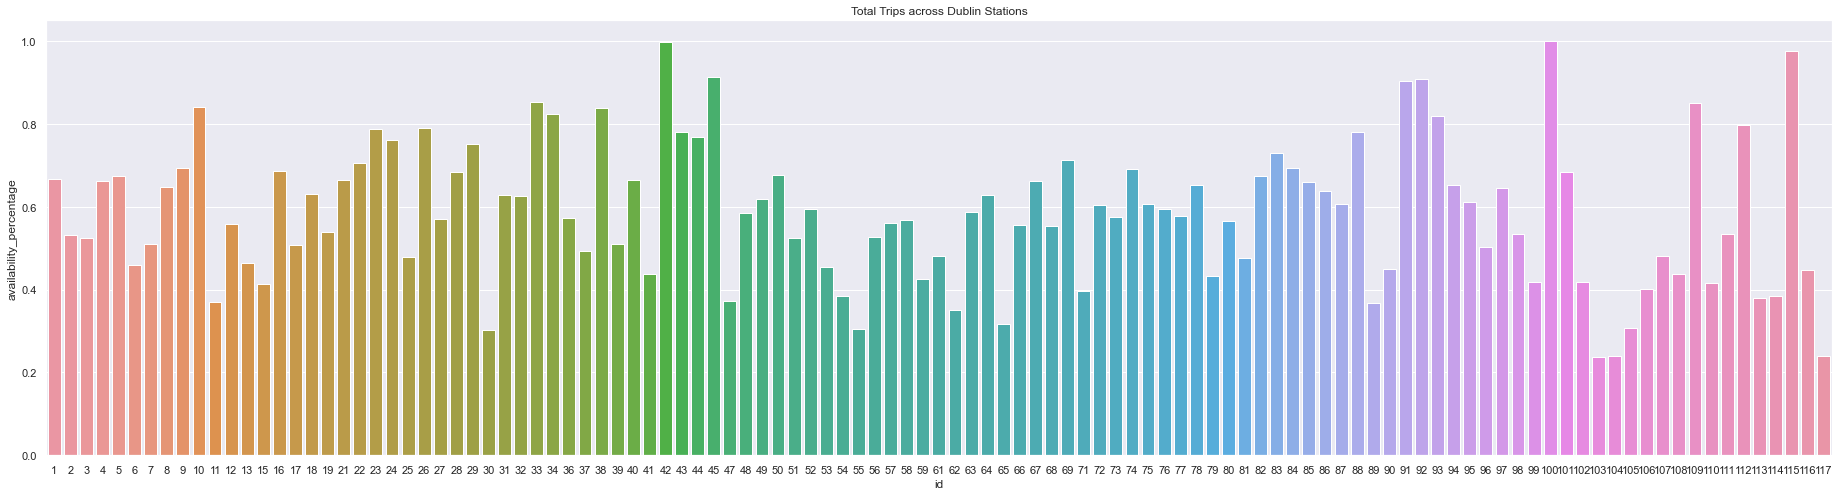

In [11]:
station_availability = merged_data

station_availability = station_availability.groupby('id')['availability_percentage'].mean().reset_index()
station_availability['availability_percentage'] = station_availability['availability_percentage']/max(station_availability['availability_percentage'])
sns.set(rc={'figure.figsize':(32,8)})
sns.barplot(x='id', y='availability_percentage', data=station_availability, order=station_availability['id']).set_title('Total Trips across Dublin Stations')


### Hourly wise distribution of Bike Availability

No handles with labels found to put in legend.


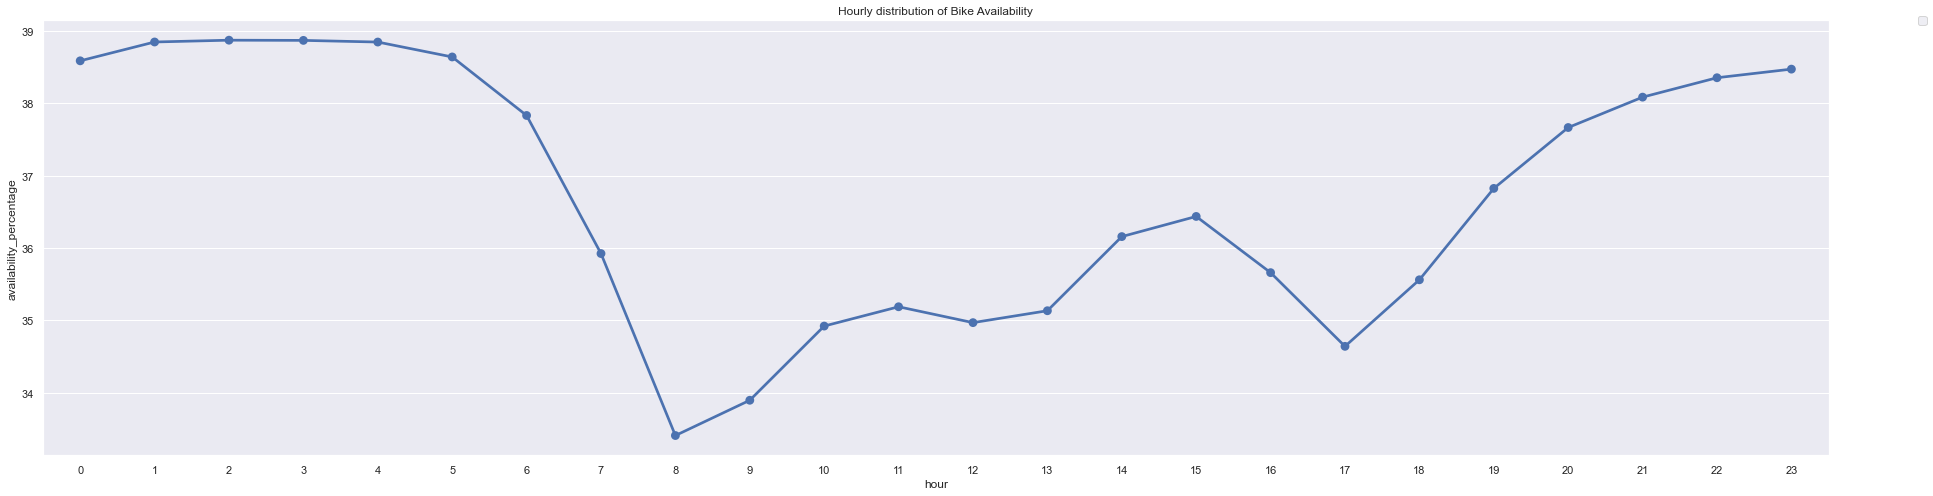

In [12]:
bike_availability_percentage_hourly = merged_data.groupby(['hour'])['availability_percentage'].mean().reset_index(name ='availability_percentage')
bike_availability_percentage_hourly['availability_percentage'] = bike_availability_percentage_hourly['availability_percentage'] * 100
bike_availability_percentage_hourly = bike_availability_percentage_hourly.sort_values(by='availability_percentage',ascending=False) 
bike_availability_percentage_hourly = bike_availability_percentage_hourly.reset_index(drop=True)
#bike_availability_percentage_year_month = bike_availability_percentage_year_month.sort_values(by=['year','hour'])
fig,ax = plt.subplots()
sns.pointplot(data=bike_availability_percentage_hourly[['availability_percentage','hour']],
              x='hour',
              y='availability_percentage',
              ax=ax)
ax.set(title="Hourly distribution of Bike Availability")

plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Season wise hourly distribution of Bike Availability

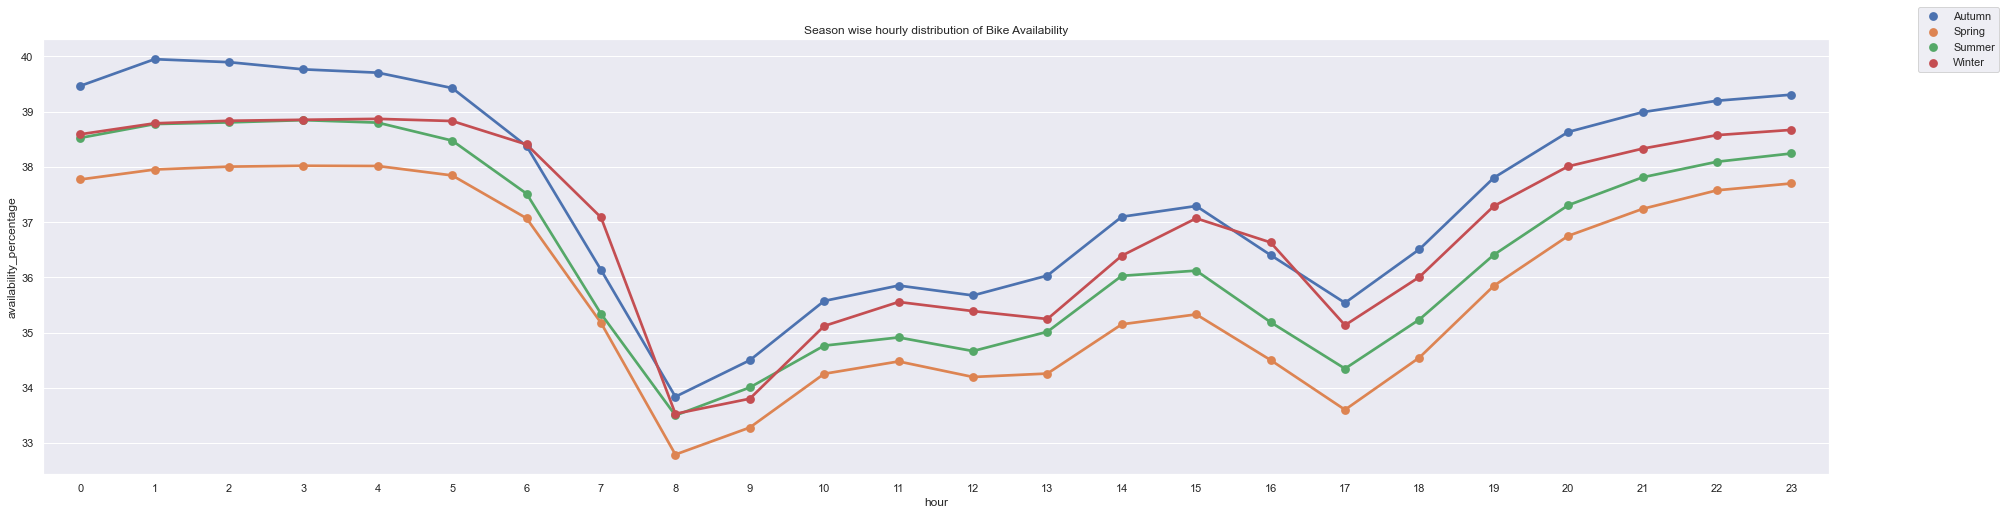

In [13]:
bike_availability_season_hour = merged_data.groupby(['season','hour'])['availability_percentage'].mean().reset_index(name ='availability_percentage')
bike_availability_season_hour = bike_availability_season_hour.sort_values(by='availability_percentage',ascending=False) 
bike_availability_season_hour['availability_percentage'] = bike_availability_season_hour['availability_percentage'] * 100
bike_availability_season_hour = bike_availability_season_hour.reset_index(drop=True)
bike_availability_season_hour = bike_availability_season_hour.sort_values(by=['season','hour'])
fig,ax = plt.subplots()
sns.pointplot(data=bike_availability_season_hour[['hour',
                           'availability_percentage',
                           'season']],
              x='hour',
              y='availability_percentage',
              hue='season',
              ax=ax)
ax.set(title="Season wise hourly distribution of Bike Availability")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Weekday wise hourly distribution of Bike Availability

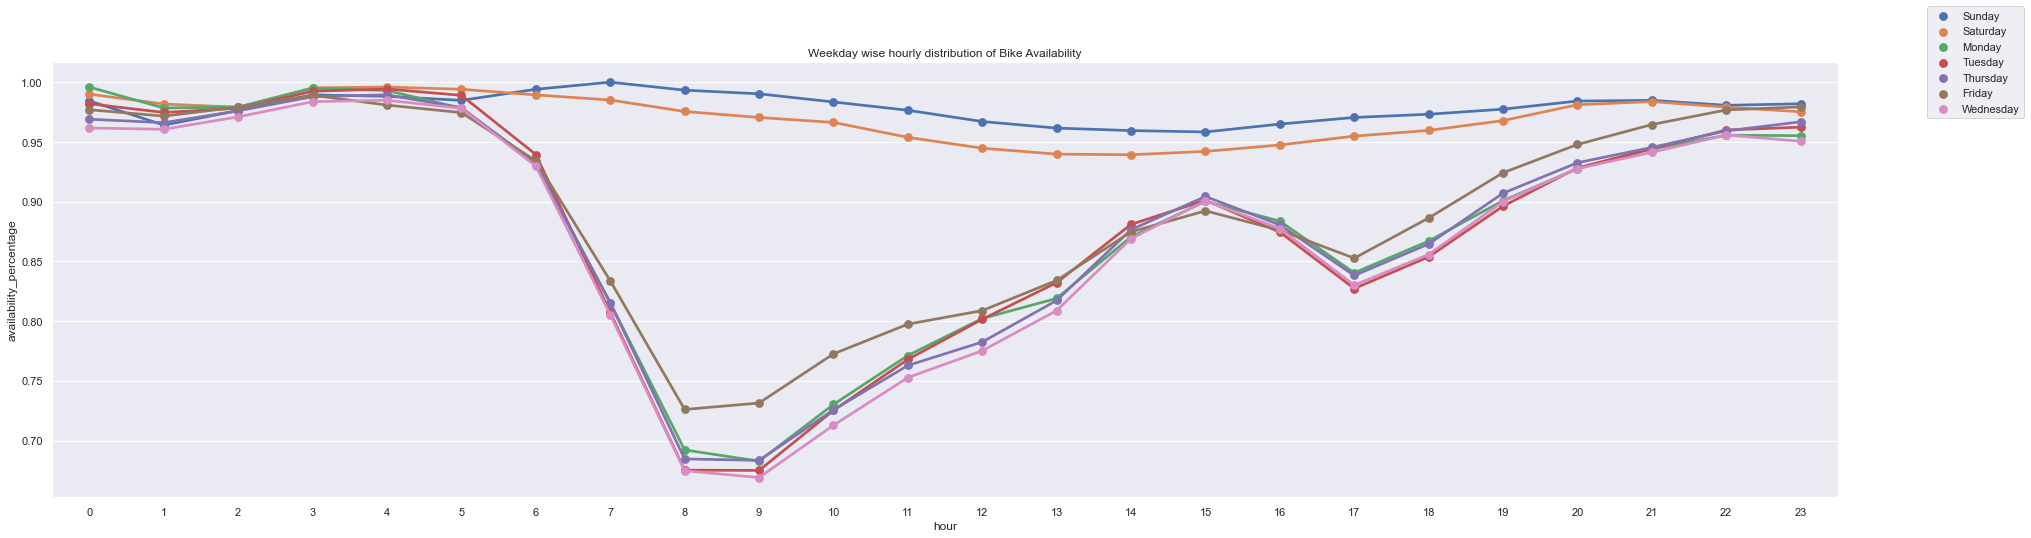

In [14]:
bike_availability_weekday_hour = merged_data.groupby(['weekday','hour'])['availability_percentage'].sum().reset_index(name ='availability_percentage')
bike_availability_weekday_hour = bike_availability_weekday_hour.sort_values(by='availability_percentage',ascending=False) 
bike_availability_weekday_hour = bike_availability_weekday_hour.reset_index(drop=True)
bike_availability_weekday_hour['availability_percentage'] = bike_availability_weekday_hour['availability_percentage']/max(bike_availability_weekday_hour['availability_percentage'])

fig,ax = plt.subplots()
sns.pointplot(data=bike_availability_weekday_hour[['hour',
                           'availability_percentage',
                           'weekday']],
              x='hour',
              y='availability_percentage',
              hue='weekday',
              ax=ax)
ax.set(title="Weekday wise hourly distribution of Bike Availability")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Explanation Pending

### Bike Availability on Holidays

### Bike Availability Analysis According to Beaufort Wind Scale

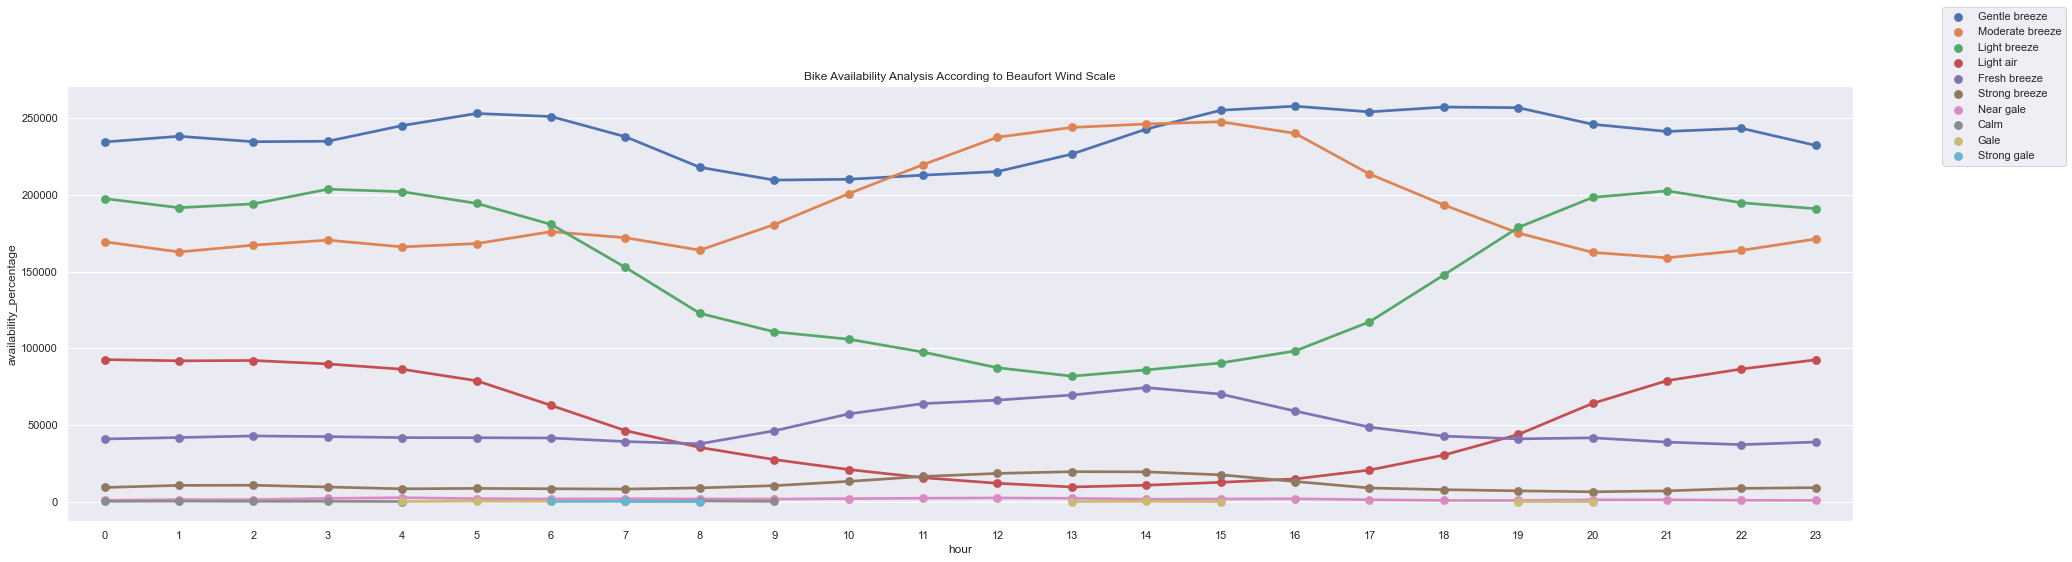

In [16]:
wind_categories_data = merged_data
wind_categories_data_weekday_hour = wind_categories_data.groupby(['wdsp_classified','hour'])['availability_percentage'].sum().reset_index(name ='availability_percentage')

#wind_categories_data_weekday_hour['availability_percentage'] = wind_categories_data_weekday_hour['availability_percentage']/max(wind_categories_data_weekday_hour['availability_percentage'])


wind_categories_data_weekday_hour = wind_categories_data_weekday_hour.sort_values(by='availability_percentage',ascending=False) 
wind_categories_data_weekday_hour = wind_categories_data_weekday_hour.reset_index(drop=True)


fig,ax = plt.subplots()
sns.pointplot(data=wind_categories_data_weekday_hour[['hour',
                           'availability_percentage',
                           'wdsp_classified']],
              x='hour',
              y='availability_percentage',
              hue='wdsp_classified',
              ax=ax)
ax.set(title="Bike Availability Analysis According to Beaufort Wind Scale")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


# Clustering Analysis 

We  were interested  to  understand  and  find  out  if  there  are  a  couple  of  different  behaviours  or patterns that all stations could be categorised into, and how this might vary around the city. The bikes  are  used  generally  for  commuting  to  and  from  work,  within  the  city,  so  it  seems  very natural  that  some  kind  of  spatial  pattern  would  occur  within  the  stations.  For  this  purpose, clustering  the  stations  according  to  their  percentage  bike  availability  or  capacity  was  analysed.Weused K-Means clustering to achieve this.K-Means works by making an assumption prior to computation that there are a number of ‘k’ different clusters or categories into which our data can be categorized


#### Explanation about Data Transformation for K-means clustering is pending 

In [17]:
#group data into clusters
clustering_df = merged_data[['id', 'name', 'latitude', 'longitude', 'day_type', 'classified_time', 'availability_percentage','cluster_group']]
clustering_df = clustering_df.groupby(['id', 'name', 'latitude', 'longitude', 'cluster_group'],as_index=False)['availability_percentage'].mean()
clustering_df  = clustering_df.set_index('id')
clustering_df.sample(5)


,name,latitude,longitude,cluster_group,availability_percentage
id,,,,,
84,BROOKFIELD ROAD,53.339005,-6.300217,11AM-3PM Weekday,0.169174
28,MOUNTJOY SQUARE WEST,53.356299,-6.258586,6AM-10AM Sunday,0.308999
117,HANOVER QUAY EAST,53.343653,-6.231755,6AM-10AM Saturday,0.137892
5,CHARLEMONT PLACE,53.330662,-6.260177,11AM-3PM Saturday,0.359002
2,BLESSINGTON STREET,53.356769,-6.268140,4PM-7PM Sunday,0.224861


In [18]:
#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['name', 'id','latitude', 'longitude'] , columns=['cluster_group'], values='availability_percentage')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('name')
clustering_df = clustering_df.apply(lambda x: x.fillna(x.mean()),axis=0)

#clustering_df.sample(5)

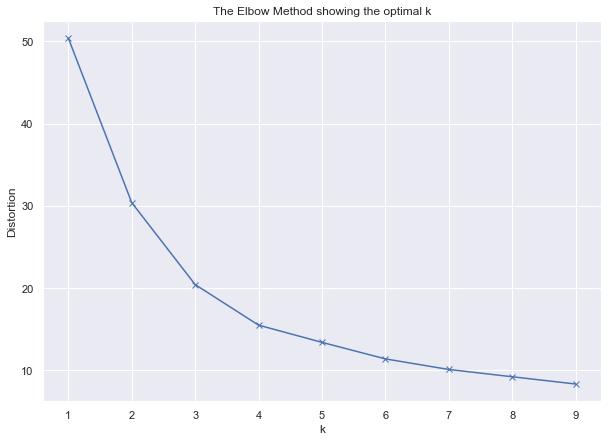

In [19]:
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['id', 'latitude', 'longitude'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
#clustering algo
X = np.array(clustering_df.drop(['id', 'latitude', 'longitude'], 1).astype(float))
KM = KMeans(n_clusters=4) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()
locations.head(5)

cluster_group,name,id,latitude,longitude,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday,Cluster
0,AVONDALE ROAD,108,53.359405,-6.276142,0.193366,0.187029,0.196426,0.198455,0.209559,0.271469,0.267000,0.192221,0.205245,0.220845,0.262408,0.362528,0.361756,0.244947,0.383495,1
1,BENSON STREET,90,53.344153,-6.233451,0.217310,0.234680,0.566508,0.187803,0.230315,0.216008,0.230132,0.242940,0.478934,0.194031,0.246867,0.145038,0.155561,0.204765,0.172322,1
2,BLACKHALL PLACE,88,53.348800,-6.281637,0.319896,0.321664,0.198484,0.367582,0.368007,0.404228,0.545843,0.483031,0.340576,0.462906,0.528008,0.697253,0.685294,0.539220,0.761296,0
3,BLESSINGTON STREET,2,53.356769,-6.268140,0.204693,0.166914,0.196898,0.226250,0.224861,0.258475,0.274327,0.223327,0.213755,0.257747,0.310293,0.485105,0.481489,0.330890,0.565258,0
4,BOLTON STREET,3,53.351182,-6.269859,0.426210,0.361134,0.251310,0.520675,0.479265,0.217482,0.316522,0.448689,0.201217,0.549643,0.476359,0.317051,0.430606,0.545966,0.363671,3


In [21]:
locations.columns
col_list = ['11AM-3PM Saturday',
       '11AM-3PM Sunday', '11AM-3PM Weekday', '4PM-7PM Saturday',
       '4PM-7PM Sunday', '4PM-7PM Weekday', '6AM-10AM Saturday',
       '6AM-10AM Sunday', '6AM-10AM Weekday', '8PM-11PM Saturday',
       '8PM-11PM Sunday', '8PM-11PM Weekday', 'Overnight Saturday',
       'Overnight Sunday', 'Overnight Weekday']
locations['rank'] = locations[col_list].mean(axis=1)
locations = locations.sort_values(['rank'])
locations.sample(5)

cluster_group,name,id,latitude,longitude,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday,Cluster,rank
97,ST JAMES HOSPITAL (LUAS),80,53.341359,-6.292951,0.373503,0.284909,0.291186,0.322650,0.264047,0.310511,0.404976,0.316920,0.344720,0.303810,0.291083,0.401834,0.394192,0.320703,0.434647,0,0.337313
26,EXCHEQUER STREET,9,53.343034,-6.263578,0.774233,0.754317,0.661903,0.663250,0.586143,0.509159,0.542142,0.549323,0.493485,0.651852,0.317587,0.274616,0.211961,0.398278,0.102339,3,0.499373
76,MOUNTJOY SQUARE WEST,28,53.356299,-6.258586,0.283984,0.251309,0.249568,0.291647,0.273747,0.308512,0.465498,0.308999,0.328947,0.314444,0.350458,0.593840,0.663484,0.414720,0.689483,0,0.385909
11,CHRISTCHURCH PLACE,6,53.343368,-6.270120,0.613269,0.637381,0.219643,0.641504,0.610263,0.232702,0.370233,0.515172,0.163535,0.624457,0.484952,0.231890,0.310564,0.490031,0.141756,3,0.419157
62,KILMAINHAM GAOL,97,53.342113,-6.310015,0.273740,0.230953,0.181214,0.251472,0.273151,0.365767,0.441372,0.292861,0.276830,0.272686,0.364484,0.630029,0.518024,0.315421,0.665202,0,0.356880


In [22]:
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.figsize'] = (10, 8)
colordict = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}
dublin_map = folium.Map([53.350140, -6.266155], zoom_start=13,attr = '© OpenStreetMap contributors, © CartoDB')
for latitude, longitude, Cluster,name in zip(locations['latitude'],locations['longitude'], locations['Cluster'],locations['name']):
    folium.CircleMarker(
        [latitude, longitude],
        color = 'b',
        radius = 6,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9,
        popup=name
        ).add_to(dublin_map)
dublin_map

In [23]:
#merge clusters back into main dataset

merged_with_clusters = merged_data
cluster_output = locations[['id', 'Cluster']]
cluster_output.drop_duplicates(keep = 'first', inplace = True)
#del merged_data
merged_with_clusters = pd.merge(merged_with_clusters, cluster_output, on = 'id', how = 'left')
#merged_with_clusters['bike_arr_dep_abs'] = abs(merged_with_clusters['bike_arr_dep'])
merged_with_clusters.sample(5)

,id,timestamp,total_bike_stands,available_bike_stands,available_bikes,year,month,day,hour,minute,weekday,number,name,latitude,longitude,holiday,season,date_for_merge,rain,temp,wdsp,wdsp_classified,date,day_type,classified_time,cluster_group,availability_percentage,is_empty,is_full,Cluster
21314831,55,2020-11-14 13:20:02,36,30,6,2020,11,14,13,20,Saturday,55,HATCH STREET,53.334030,-6.260714,casual_day,Autumn,2020-11-14 13:00:00,1.0,11.3,12.0,Moderate breeze,2020-11-14,Saturday,11AM-3PM,11AM-3PM Saturday,0.166667,0,0,1
12026640,31,2020-12-24 18:35:02,20,13,7,2020,12,24,18,35,Thursday,31,PARNELL STREET,53.350929,-6.265125,casual_day,Winter,2020-12-24 19:00:00,0.0,-0.1,8.0,Gentle breeze,2020-12-24,Weekday,4PM-7PM,4PM-7PM Weekday,0.350000,0,0,3
1515593,5,2017-02-03 03:30:02,40,18,22,2017,2,3,3,30,Friday,5,CHARLEMONT PLACE,53.330662,-6.260177,casual_day,Winter,2017-02-03 04:00:00,0.1,4.4,21.0,Fresh breeze,2017-02-03,Weekday,Overnight,Overnight Weekday,0.550000,0,0,0
40219160,101,2021-03-02 13:20:03,30,22,8,2021,3,2,13,20,Tuesday,101,KING STREET NORTH,53.350291,-6.273507,casual_day,Spring,2021-03-02 13:00:00,0.0,7.8,8.0,Gentle breeze,2021-03-02,Weekday,11AM-3PM,11AM-3PM Weekday,0.266667,0,0,0
17557064,45,2020-10-04 17:20:02,30,10,20,2020,10,4,17,20,Sunday,45,DEVERELL PLACE,53.351464,-6.255265,casual_day,Autumn,2020-10-04 17:00:00,0.0,17.9,4.0,Light breeze,2020-10-04,Sunday,4PM-7PM,4PM-7PM Sunday,0.666667,0,0,2


### Bike Availablity Analysis On Weekday and Weekend 

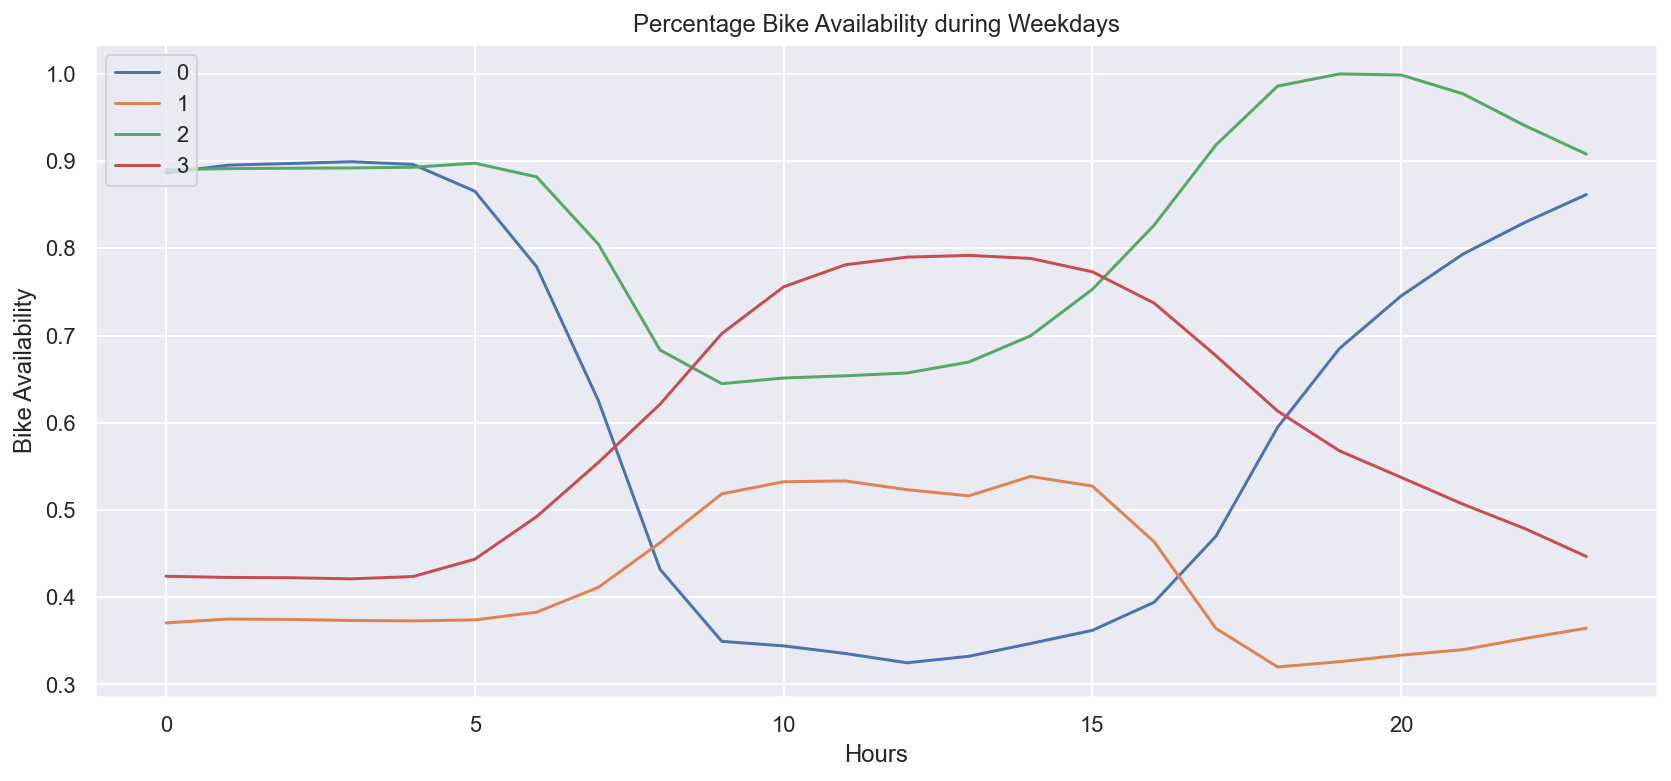

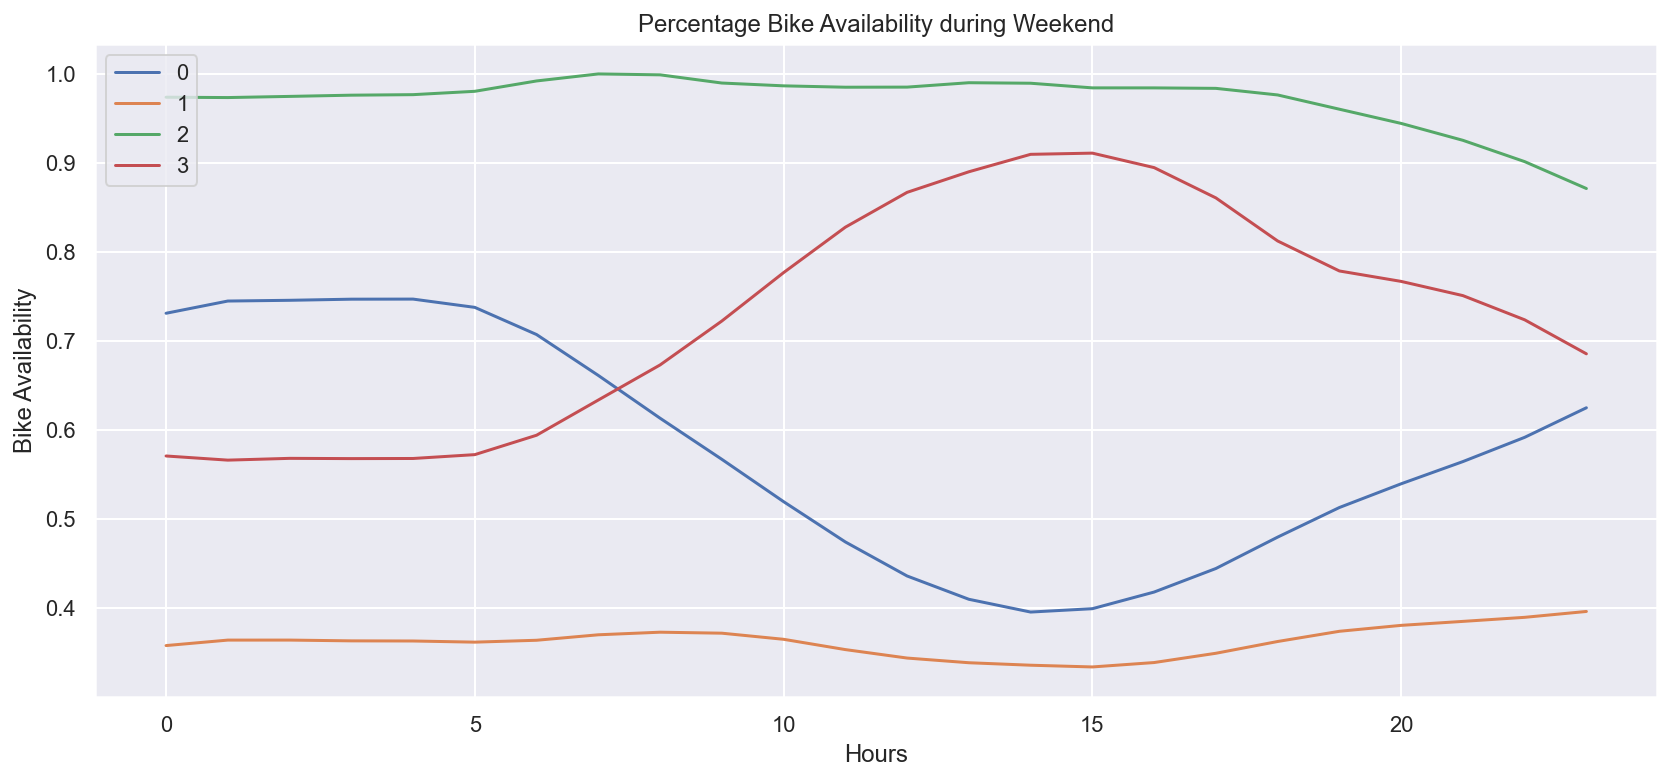

In [24]:
# # Filter weekdays
weekly_data = merged_with_clusters[(merged_with_clusters['weekday']!= "Saturday") | (merged_with_clusters['weekday']!= "Sunday")]
weekend_data = merged_with_clusters[(merged_with_clusters['weekday']== "Saturday") | (merged_with_clusters['weekday']== "Sunday")]

# Group by clusters first, then by hours, taking mean all the availability_percentage values
weekly_data = weekly_data.groupby(['Cluster','hour'])['availability_percentage'].mean()
weekend_data = weekend_data.groupby(['Cluster','hour'])['availability_percentage'].mean()

# Normalizing the grouped results
weekly_data = weekly_data/weekly_data.max()
weekend_data = weekend_data/weekend_data.max()

# Plot the results for weekly data
plt.figure(figsize=(14,6))
for i in range(len(set(clusters))):
  plt.plot(weekly_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Percentage Bike Availability during Weekdays')
plt.xlabel('Hours')
plt.ylabel('Bike Availability')
plt.show()

# Plot the results for weekend
plt.figure(figsize=(14,6))
for i in range(len(set(clusters))):
  plt.plot(weekend_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Percentage Bike Availability during Weekend')
plt.xlabel('Hours')
plt.ylabel('Bike Availability')
plt.show()


[Text(0.5, 1.0, 'Bike Availability heat map for HEUSTON STATION (CAR PARK)')]

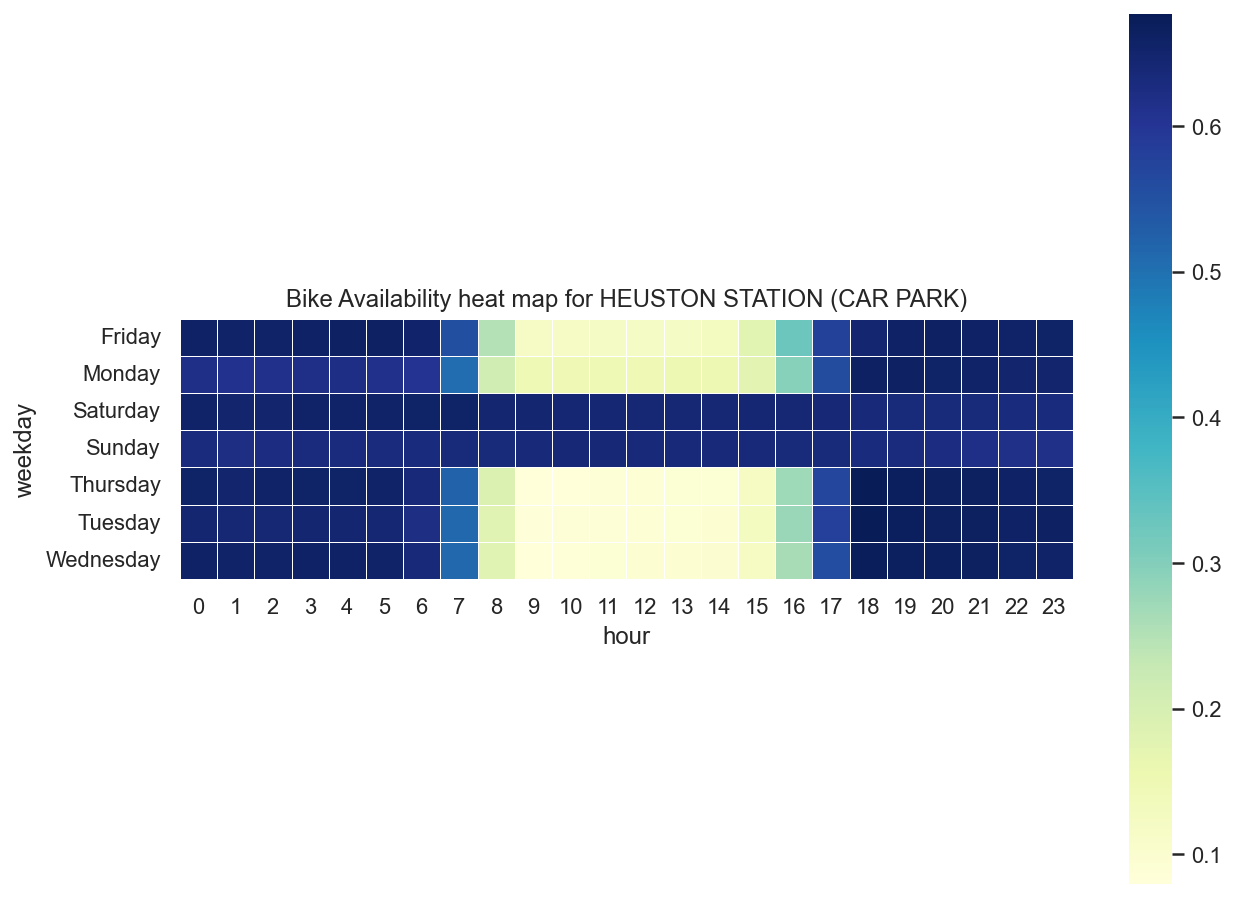

In [50]:
### HEUSTON STATION (CAR PARK)

#fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
overall_availability_id = merged_with_clusters[merged_with_clusters['id'] == 93]
overall_availability_id = overall_availability_id.groupby(['id','weekday','hour'])['availability_percentage'].mean().reset_index()

d = overall_availability_id.pivot("weekday", "hour", "availability_percentage")
d = d.fillna(d.mean())
ax = sns.heatmap(d,linewidths=0.5,cmap="YlGnBu",square= True)

ax.set(title="Bike Availability heat map for HEUSTON STATION (CAR PARK)")
